# Q1

## Q1 part 1

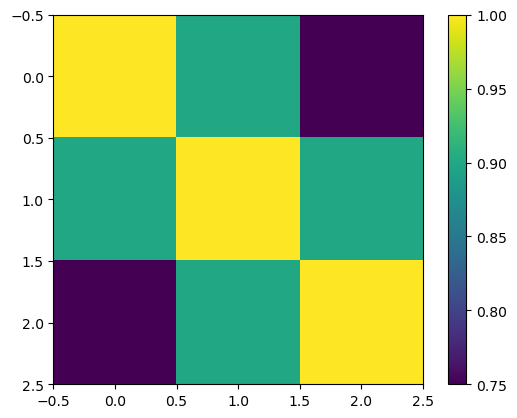

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();

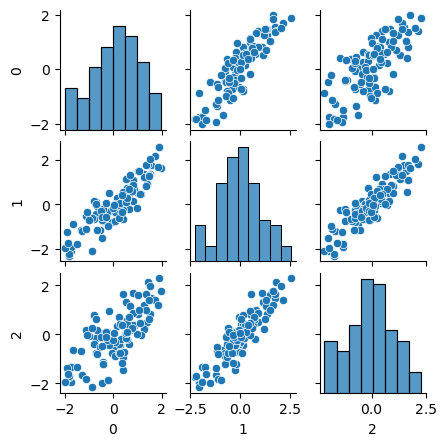

In [7]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

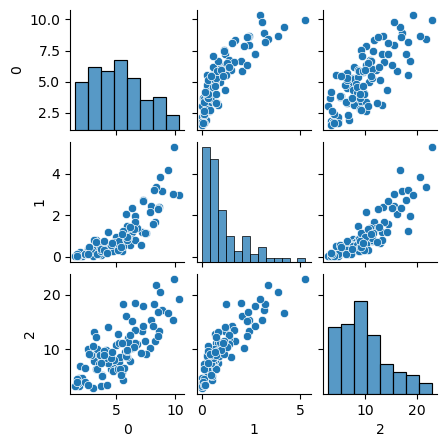

In [8]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [9]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])

    y0_ = pm.Deterministic('y0_', pm.Normal.icdf( 
              pm.math.exp(pm.logcdf(pm.Gamma.dist(alpha=p0, beta=1), y0)), 
                                                    mu=0, sigma=1))

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])

    y1_ = pm.Deterministic('y1_', pm.Normal.icdf( 
              pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)),
                                                    mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_', pm.Normal.icdf(
              pm.math.exp(pm.logcdf(pm.ChiSquared.dist(nu=p2), y2)),
                                                   mu=0, sigma=1))

    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                      sd_dist=pm.Exponential.dist(1.0, shape=3),
                      compute_corr=True)

    potential = pm.Potential("MVNeval", pm.logp(pm.MvNormal.dist(mu=0, cov=R), pm.math.concatenate([y0_,y1_,y2_], axis=1)))

    idata = pm.sample()

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(bool, shape=(1, 1))) must be compatible with the type of the original Variable (Matrix(bool, shape=(100, 1))). local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_elemwise
ERROR (pytensor.graph.rewriting.basic): node: And(Lt.0, [[False] [ ... ] [False]])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1968, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/opt/conda/lib/python3.11/site-packages/pytensor/graph/features.py", line 626, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason=reason, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/pytho

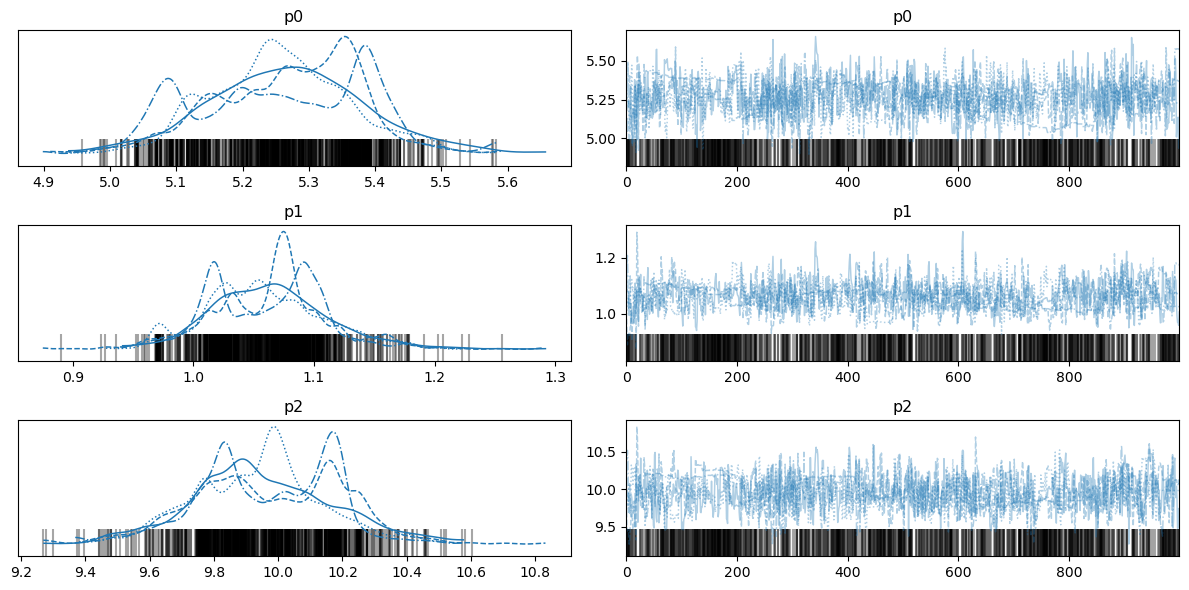

In [10]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

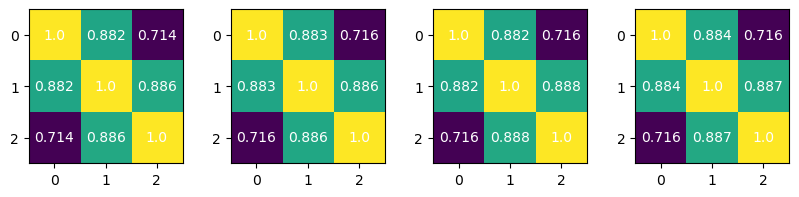

In [11]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)), 
                       color='w', va='center', ha='center')

# Explanation

### 1) Goal
We want to provide a **posterior inference** on the dependency structure among three non-normal variables (Gamma, Exponential, Chi-square) by building a **copula model** in PyMC. Each dimension has its own marginal distribution, and we place a correlation prior on the latent normal variables that underlie these marginals.

### 2) Steps in the Code

1. **Data Generation** (or loading your own real data)
   - We create a 3D correlated normal dataset `x_latent`, then transform each column to a different non-normal distribution. 
   - If you have real data with columns of non-normal variables, replace that block with reading your data into `df` or `y_data`.

2. **Marginal Likelihood**  
   - For each dimension, we define a PyMC distribution matching the chosen marginal (Gamma, Exponential, Chi-square). 
   - The observed variable is `col0_obs`, `col1_obs`, `col2_obs` for each dimension.

3. **Latent Normal Transform**  
   - We convert each dimension’s observed variable to a latent normal variable by taking the CDF of that distribution and then applying `pm.Normal.icdf(...)`. 
   - E.g. `col0_latent = Normal.icdf( GammaCDF(col0_obs) )`. 
   - This yields a latent variable that *should* be standard normal if there's no correlation, but we want correlation.

4. **Correlation with LKJ**  
   - We define `L,R,stds = pm.LKJCholeskyCov(...)` for an `n=3` correlation matrix. 
   - Then we impose a potential on `(col0_latent, col1_latent, col2_latent)` so they come from `MvNormal(0, R)`. 
   - This effectively forms a **Gaussian copula** linking the 3 marginals with correlation `R`.

5. **MCMC & Summaries**  
   - We sample with `pm.sample(return_inferencedata=True, idata_kwargs={"log_likelihood": True})`. 
   - We can then compute WAIC/LOO by referencing the observed variable names, e.g. `az.waic(..., var_name=["col0_obs","col1_obs","col2_obs"])`. 
   - We examine the posterior correlation matrix in `R` or `R_corr`.

### 3) Practical Considerations

- If your real data has, say, 5 or more columns, you can generalize this approach. Each column might have a different parametric distribution. You define each dimension's marginal parameters, do the `icdf` transform to latent normal, then define a correlation prior in the latent space. 
- The code includes a `Potential` to tie the latent variables together. 
- For large dimensionality, you might need more advanced methods or a more flexible correlation prior (like `eta=1` or partial correlation constraints).

### 4) Conclusion

This notebook demonstrates a **copula-based** Bayesian inference on non-normal data with distinct marginals. We learn both each marginal’s parameters and the correlation structure in a single PyMC model. The result is a posterior distribution over the correlation matrix and marginal parameters, giving us a full view of the dependency among these non-normal variables.


## Q1 part 2

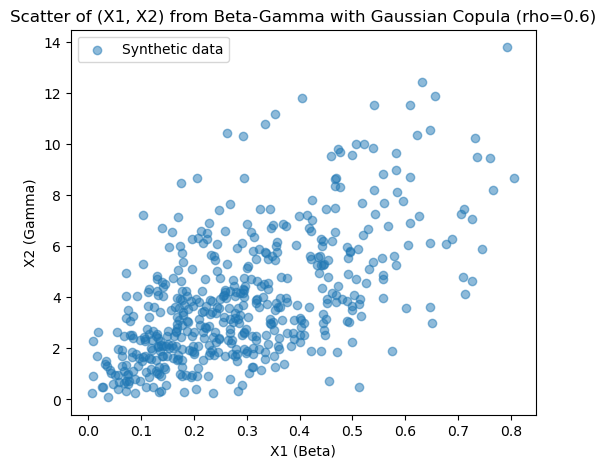

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha_beta, beta_beta]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Marginal 1 (Beta) summary:


mean     sd  hdi_3%  hdi_97%
alpha_beta  1.845  0.102   1.661    2.042
beta_beta   4.430  0.262   3.935    4.893

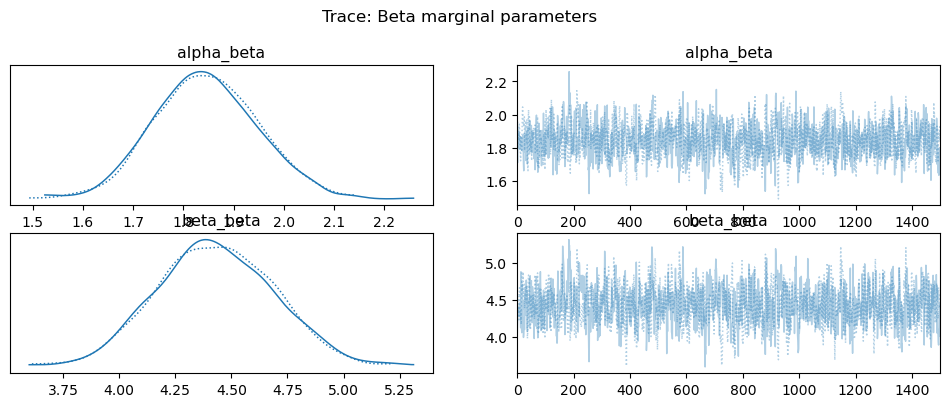

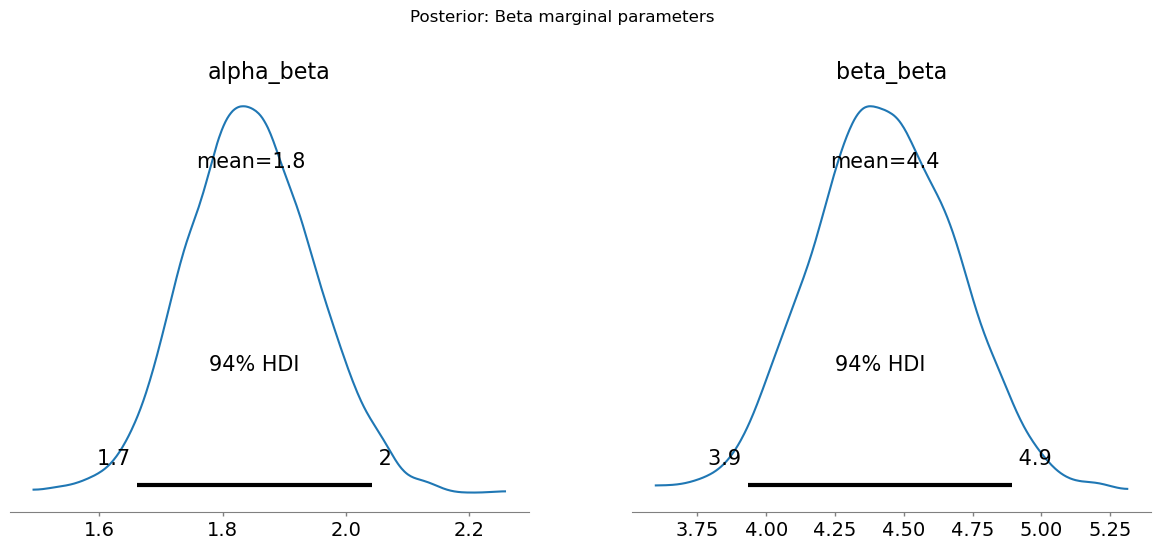

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha_gamma, beta_gamma]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Marginal 2 (Gamma) summary:


mean     sd  hdi_3%  hdi_97%
alpha_gamma  2.288  0.131   2.050    2.529
beta_gamma   0.587  0.037   0.519    0.657

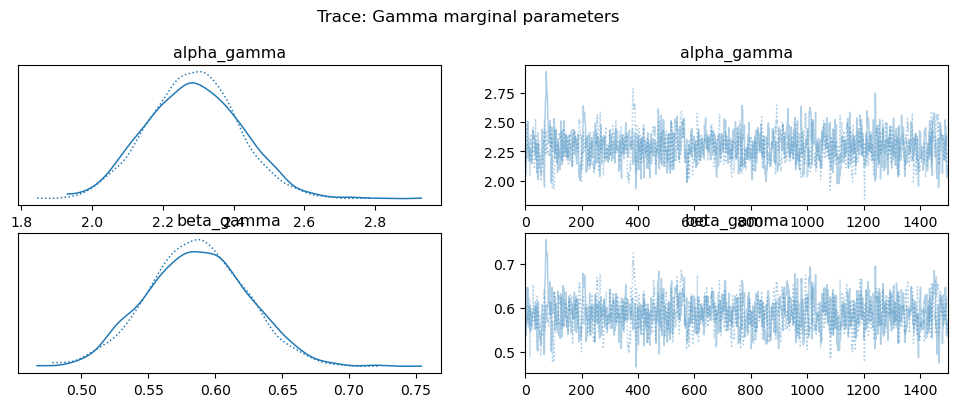

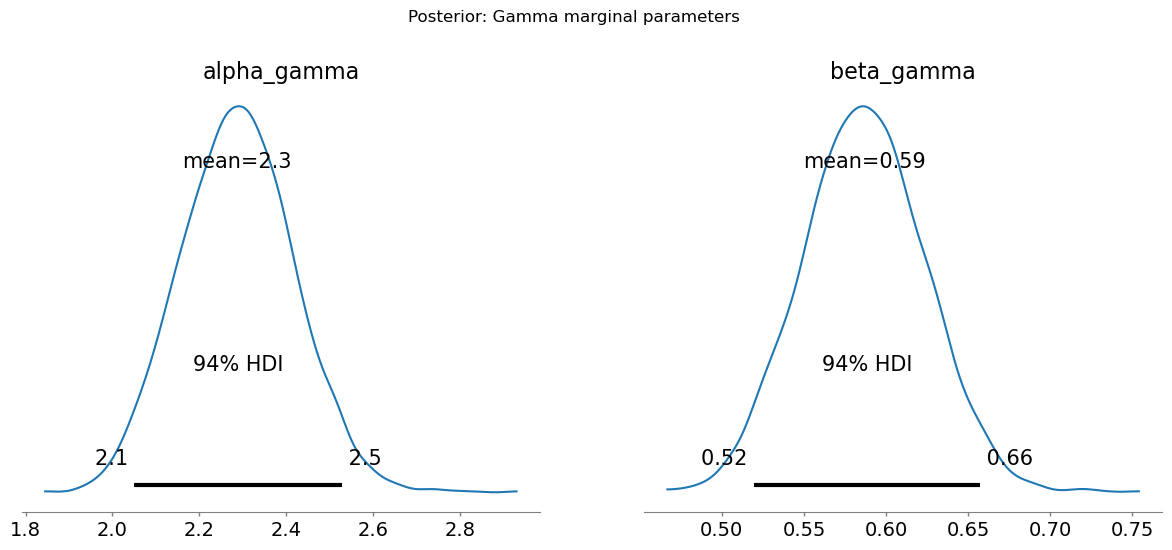

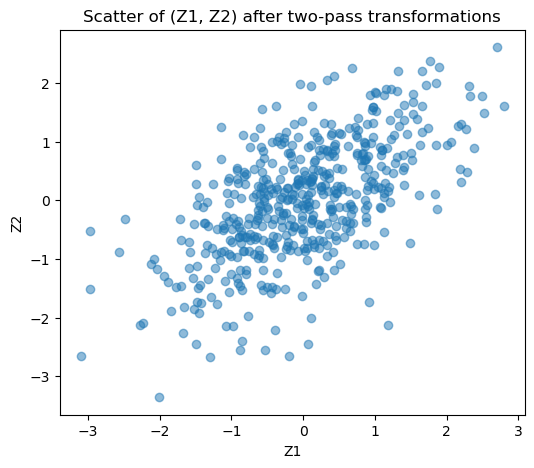

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [chol_cov]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Copula Model - Cholesky Factor summary:


mean     sd  hdi_3%  hdi_97%
chol_cov[0]  0.990  0.030   0.935    1.049
chol_cov[1]  0.605  0.040   0.525    0.677
chol_cov[2]  0.800  0.026   0.750    0.849


Copula Model - Correlation matrix 'R' summary:


mean     sd  hdi_3%  hdi_97%
R[0, 0]  1.000  0.000   1.000    1.000
R[0, 1]  0.602  0.028   0.552    0.658
R[1, 0]  0.602  0.028   0.552    0.658
R[1, 1]  1.000  0.000   1.000    1.000


True correlation = 0.600, Posterior mean correlation = 0.602


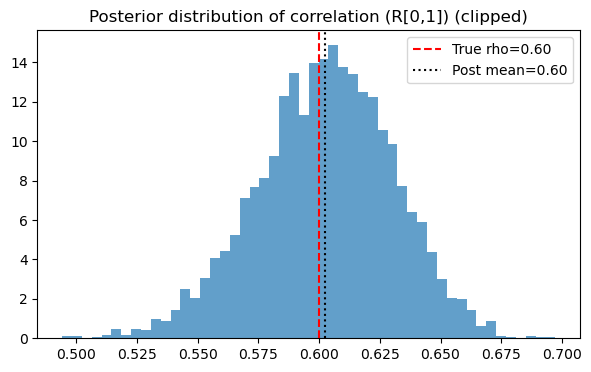

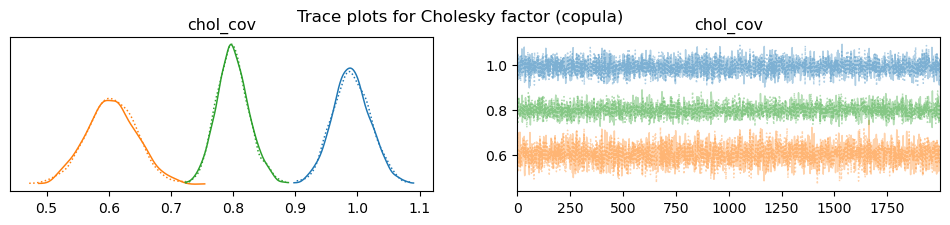

In [11]:
############################################################
# Q1 Two-Pass Copula Approach
# 
# 1) Generate synthetic data from Beta-Gamma marginals via a Gaussian copula correlation.
# 2) First pass: Fit each marginal (Beta for X1, Gamma for X2) separately.
# 3) Second pass: Estimate correlation with a Gaussian copula, using the fitted marginals.
# 4) Avoid OverflowError by manually clipping extreme correlation draws for plotting, 
#    and skip direct ArviZ KDE on "R" to prevent numeric issues.
# 5) Provide additional visualizations to illustrate data and posteriors.
#
# NOTE:
#  - This code assumes PyMC >= 4.0, returning an InferenceData object from pm.sample().
#  - We store the correlation matrix in "R" as a Deterministic variable so we can retrieve it from the trace.
#  - We handle numeric extremes by clipping correlation draws for plotting or skipping direct KDE on "R".
############################################################

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

from scipy.stats import beta as beta_stat
from scipy.stats import gamma as gamma_stat
from scipy.special import erfinv

# ---------------------------------------------------------
# (A) Generate Synthetic Data
# ---------------------------------------------------------
rng = np.random.default_rng(42)
N = 500

# True correlation in latent normal space
rho_true = 0.6
cov = np.array([[1, rho_true],
                [rho_true, 1]])
mean = np.zeros(2)

z = rng.multivariate_normal(mean, cov, size=N)  # shape (N,2)

def std_normal_cdf(x):
    # approximate standard normal CDF using error function
    return 0.5 * (1 + pm.math.erf(x / np.sqrt(2))).eval()

u1 = std_normal_cdf(z[:,0])
u2 = std_normal_cdf(z[:,1])

# X1 ~ Beta(2,5), X2 ~ Gamma(k=2, scale=2)
X1_data = beta_stat(a=2, b=5).ppf(u1)
X2_data = gamma_stat(a=2, scale=2).ppf(u2)

# Quick scatter plot of raw data
plt.figure(figsize=(6,5))
plt.scatter(X1_data, X2_data, alpha=0.5, label="Synthetic data")
plt.title("Scatter of (X1, X2) from Beta-Gamma with Gaussian Copula (rho=0.6)")
plt.xlabel("X1 (Beta)")
plt.ylabel("X2 (Gamma)")
plt.legend()
plt.show()

# ---------------------------------------------------------
# (B) First Pass: Fit Marginals Separately
# ---------------------------------------------------------
# 1) Beta for X1
with pm.Model() as model_marginal1:
    alpha_beta = pm.HalfNormal("alpha_beta", sigma=2.0)
    beta_beta  = pm.HalfNormal("beta_beta",  sigma=2.0)
    x1_obs     = pm.Beta("x1_obs", alpha=alpha_beta, beta=beta_beta, observed=X1_data)

    trace_marginal1 = pm.sample(
        draws=1500, tune=1000, target_accept=0.9, random_seed=42, cores=1
    )

print("Marginal 1 (Beta) summary:")
display(az.summary(trace_marginal1, var_names=["alpha_beta","beta_beta"], kind="stats"))

az.plot_trace(trace_marginal1, var_names=["alpha_beta","beta_beta"])
plt.suptitle("Trace: Beta marginal parameters", y=1.02)
plt.show()

az.plot_posterior(trace_marginal1, var_names=["alpha_beta","beta_beta"])
plt.suptitle("Posterior: Beta marginal parameters", y=1.02)
plt.show()

# 2) Gamma for X2
with pm.Model() as model_marginal2:
    alpha_gamma = pm.HalfNormal("alpha_gamma", sigma=2.0)  # shape param
    beta_gamma  = pm.HalfNormal("beta_gamma",  sigma=2.0)  # rate param
    x2_obs      = pm.Gamma("x2_obs", alpha=alpha_gamma, beta=beta_gamma, observed=X2_data)

    trace_marginal2 = pm.sample(
        draws=1500, tune=1000, target_accept=0.9, random_seed=42, cores=1
    )

print("\nMarginal 2 (Gamma) summary:")
display(az.summary(trace_marginal2, var_names=["alpha_gamma","beta_gamma"], kind="stats"))

az.plot_trace(trace_marginal2, var_names=["alpha_gamma","beta_gamma"])
plt.suptitle("Trace: Gamma marginal parameters", y=1.02)
plt.show()

az.plot_posterior(trace_marginal2, var_names=["alpha_gamma","beta_gamma"])
plt.suptitle("Posterior: Gamma marginal parameters", y=1.02)
plt.show()

# ---------------------------------------------------------
# (C) Second Pass: Gaussian Copula for Correlation
# ---------------------------------------------------------
# We'll use the posterior means for each marginal's parameters to approximate their CDF.

alpha_beta_post = float(trace_marginal1.posterior["alpha_beta"].mean().values)
beta_beta_post  = float(trace_marginal1.posterior["beta_beta"].mean().values)
alpha_gamma_post= float(trace_marginal2.posterior["alpha_gamma"].mean().values)
beta_gamma_post = float(trace_marginal2.posterior["beta_gamma"].mean().values)

def cdf_beta(x, alpha, beta):
    return beta_stat(a=alpha, b=beta).cdf(x)

def cdf_gamma(x, alpha, rate):
    return gamma_stat(a=alpha, scale=1.0/rate).cdf(x)

U1_est = cdf_beta(X1_data, alpha_beta_post, beta_beta_post)
U2_est = cdf_gamma(X2_data, alpha_gamma_post, beta_gamma_post)

def std_normal_ppf(u):
    return np.sqrt(2)*erfinv(2*u - 1)

Z1 = std_normal_ppf(U1_est)
Z2 = std_normal_ppf(U2_est)
Z_data = np.column_stack([Z1, Z2])

# Quick scatter in Z-space
plt.figure(figsize=(6,5))
plt.scatter(Z1, Z2, alpha=0.5)
plt.title("Scatter of (Z1, Z2) after two-pass transformations")
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.show()

# Copula model
with pm.Model() as copula_model:
    sd_dist = pm.HalfNormal.dist(sigma=1.0)
    chol, R_matrix, stds = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )
    Sigma = pm.Deterministic("Sigma", chol @ chol.T)
    # Store correlation matrix R
    R = pm.Deterministic("R", R_matrix)

    obs = pm.MvNormal("obs", mu=np.zeros(2), cov=Sigma, observed=Z_data)

    trace_copula = pm.sample(
        draws=2000, tune=1000, target_accept=0.9, random_seed=42, cores=1
    )

# Summaries
print("\nCopula Model - Cholesky Factor summary:")
display(az.summary(trace_copula, var_names=["chol_cov"], kind="stats"))

print("\nCopula Model - Correlation matrix 'R' summary:")
display(az.summary(trace_copula, var_names=["R"], kind="stats"))

# ---------------------------------------------------------
# (D) Visualize correlation posterior without OverflowError
# ---------------------------------------------------------
R_post = trace_copula.posterior["R"].values  # shape (chain, draw, 2, 2)
rho_samples = R_post[..., 0, 1].flatten()    # correlation draws
# Clip to avoid infinite extremes
rho_samples_clipped = np.clip(rho_samples, -0.9999, 0.9999)

rho_est = rho_samples_clipped.mean()
print(f"\nTrue correlation = {rho_true:.3f}, Posterior mean correlation = {rho_est:.3f}")

# Manual histogram
plt.figure(figsize=(7,4))
plt.hist(rho_samples_clipped, bins=50, alpha=0.7, density=True)
plt.axvline(rho_true, color='r', linestyle='--', label=f"True rho={rho_true:.2f}")
plt.axvline(rho_est, color='k', linestyle=':', label=f"Post mean={rho_est:.2f}")
plt.title("Posterior distribution of correlation (R[0,1]) (clipped)")
plt.legend()
plt.show()

# We can still do partial trace plots for 'chol_cov' (but skip direct KDE on 'R')
az.plot_trace(trace_copula, var_names=["chol_cov"])
plt.suptitle("Trace plots for Cholesky factor (copula)", y=1.02)
plt.show()

# Explanation

**1) Two-Pass Copula Approach**

- **First Pass (Marginals):**  
  We separately fit a Beta($\alpha,\beta$) distribution to $X_1$ and a Gamma($\alpha,\text{rate}$) distribution to $X_2$.  
  Each is modeled in PyMC with half-normal priors on the parameters. We sample from these two models to get posterior distributions of $\alpha_\mathrm{beta}, \beta_\mathrm{beta}$ and $\alpha_\mathrm{gamma}, \beta_\mathrm{gamma}$, respectively.

- **Second Pass (Correlation via Gaussian Copula):**  
  1. We take the posterior means of the marginal parameters (i.e. $\hat\alpha_\mathrm{beta},\hat\beta_\mathrm{beta},\hat\alpha_\mathrm{gamma},\hat\beta_\mathrm{gamma}$) as an approximation to each distribution's CDF.  
  2. We transform each observed $X_1,X_2$ into $U_1,U_2$ by applying these CDFs.  
  3. We map $U_1,U_2$ to latent normal variables $Z_1,Z_2$ using $\Phi^{-1}(U)$.  
  4. Finally, we fit a bivariate normal to $(Z_1,Z_2)$ using an LKJ prior on the correlation. This yields a posterior distribution for the correlation parameter.

**2) What is a Copula?**

A **copula** is a function that “couples” multivariate distribution functions to their one-dimensional marginals. Specifically, a Gaussian copula assumes that the correlation structure is described by a latent multivariate normal, but the marginal distributions can be arbitrary (Beta, Gamma, etc.). This two-step method decouples marginal estimation from correlation estimation.

**3) How the Two Versions of Code Implement It**

- **Version 1**: We build separate models for each marginal, ignoring correlation, to estimate each distribution's parameters.  
- **Version 2**: Using the fitted marginals, we transform data to $U(0,1)$ scale, then to latent normal $Z$-space, and fit a bivariate normal. This effectively imposes a Gaussian copula correlation.

**4) Extending to Arbitrary Multivariate GLM Regressions**

To generalize:

1. **Marginal GLMs**: For each dimension $d$ of your multivariate response, define a generalized linear model (GLM) with its own link function and prior structure, then fit to get posterior draws of the marginal parameters.  
2. **Copula Correlation**: Convert each dimension’s data to uniform scale (via the fitted marginal CDF), then to latent normal.  
3. **Correlated Model**: Place a prior on the correlation matrix (e.g. LKJ) and fit the joint correlation in the latent normal space.  
4. **Model Inference**: Sample from the resulting copula-based model to capture both the marginal behaviors and their dependencies.

By following this approach, one can handle complex or heterogeneous marginals (different GLMs for different outcomes) while still capturing dependence with a Gaussian copula. This is particularly useful in fields like finance, insurance, or any domain requiring flexible, correlated, multi-outcome modeling.


## Q1 part 3

**What Is a Copula?**

A **copula** is a mathematical function that allows us to separate the *marginal distributions* of multiple random variables from their *joint dependence structure*. In simpler terms, it “couples” each variable’s marginal distribution to form a joint distribution with a specified correlation or dependency pattern. This is particularly valuable when each dimension has a different (possibly non-normal) marginal distribution, yet we still want to capture their correlation.

---

### 1) Conceptual Overview

- **Key Idea**: In many applications, each dimension \( X_i \) might follow a distinct marginal distribution—e.g., Gamma, Exponential, Chi-Square—but we also suspect these variables are correlated. A copula-based approach says:
  1. **Preserve** each dimension’s marginal distribution as is.
  2. **Represent** the correlation by mapping each dimension into a common latent space (often a standard normal) and imposing a correlation matrix in that latent space.

- **Gaussian Copula**: A common choice is the Gaussian (normal) copula, where each dimension’s data is mapped to a latent normal variable, and a correlation matrix is placed on those latent variables. This yields a joint distribution with user-chosen marginals and a flexible correlation structure.

---

### 2) Two Main Implementation Approaches

#### **(A) Two-Pass Approach**

1. **First Pass (Marginals)**  
   - Fit each dimension’s marginal distribution separately (e.g., Gamma, Exponential).  
   - Obtain parameter estimates or full posterior for each marginal’s CDF.

2. **Second Pass (Correlation)**  
   - Transform observed data to uniform \([0,1]\) scale using the fitted marginal CDF, then to latent normal via \( \Phi^{-1} \).  
   - Fit a separate model (often using an LKJ prior) to learn the correlation in the latent space.  
   - This can be simpler but does not fully propagate uncertainty between marginal fits and the correlation.

#### **(B) Single-Model Approach (All in One)**

In this unified approach:

1. **Specify Marginals**: Each dimension is assigned a parametric distribution (Gamma, Exponential, etc.) *within the same model*.
2. **Latent Transform**: We define a deterministic transformation mapping each observed dimension to a latent normal variable:
   \[
     y_i^* = \Phi^{-1}\bigl(F_i(y_i)\bigr),
   \]
   where \( F_i \) is the \(i\)-th marginal CDF, and \( \Phi^{-1} \) is the inverse standard normal CDF.
3. **Correlation Prior**: We place an LKJ (or other) prior on the correlation of \((y_1^*, y_2^*, \dots)\). A `pm.Potential` is often used to sum the log-prob of a multivariate normal on the latent variables.

**Pros**:
- Jointly infers both marginal parameters and correlation.
- Propagates all uncertainty properly.

**Cons**:
- More code complexity and potentially slower sampling.

---

### 3) Summary of the Two Versions

1. **Two-Pass Method**  
   - **Pros**: Conceptually simpler, can do marginals first then correlation.  
   - **Cons**: Ignores joint uncertainty if done entirely separately.

2. **Single-Model Method**  
   - **Pros**: Fully Bayesian, a single integrated model for marginals and correlation.  
   - **Cons**: More complex, can be computationally heavier.

Despite these differences, both rely on the **copula concept**: each dimension’s data is mapped to uniform \([0,1]\) via its CDF, then mapped to a latent normal space, and a correlation prior is placed in that space. This effectively decouples the marginal distributions from the correlation structure—a key idea of copula modeling.


## Q1 part 4

**Using a Copula Approach to Create Arbitrary Multivariate GLM Regressions**

When extending the copula concept from simpler non‐normal variables to **multivariate generalized linear models (GLMs)**, the main idea remains the same: each dimension (or outcome) has its own marginal regression structure (e.g., logistic, Poisson, gamma regression), but we still want to capture correlation among these outcomes. Here is how to achieve that:

---

### 1) Build a Separate GLM for Each Outcome (Marginal)

Suppose we have $D$ different outcomes $Y_1, Y_2, \dots, Y_D$, each of which follows some exponential‐family distribution with a link function. For instance:

- $Y_1$ might be binary, so we use a **logit** link for logistic regression.
- $Y_2$ might be counts, so we use a **log** link for Poisson regression.
- $Y_3$ might be continuous positive, so we use a **log** link for Gamma regression.

In a standard GLM approach, we write for each outcome $Y_d$:

$
\eta_d \;=\; X_d\,\beta_d, \quad (\text{linear predictor})
$
$
g_d(\mu_d) \;=\;\eta_d, \quad (\text{link function})
$
$
Y_d \;\sim\;\text{Distribution}_d(\mu_d,\dots).
$

Here, $\beta_d$ are unknown regression coefficients, $\mu_d$ is the mean or rate parameter, and $g_d$ is the link function.

---

### 2) Map Each Outcome to a Latent Normal Variable

Once each outcome $Y_d$ has a GLM that yields a **CDF** (call it $F_d(\cdot)$) for that outcome (given its regression parameters), we can transform the observed data to a latent normal variable. Concretely, for an observed value $y_{d,i}$ (the $i$‐th data point in dimension $d$):

1. **Compute** the fitted CDF value 
$
u_{d,i} \;=\; F_d\bigl(y_{d,i}\mid \text{parameters}\bigr).
$
2. **Convert** $u_{d,i}$ to a latent normal variable 
$
z_{d,i} \;=\;\Phi^{-1}\bigl(u_{d,i}\bigr),
$
where $\Phi^{-1}$ is the inverse standard normal CDF.

In a **single‐model** PyMC approach, you can do this transformation *symbolically*:
- Define the GLM link for dimension $d$.
- Let $Y_d$ be observed under that distribution.
- Then define a `Deterministic` node $Z_d$ that calculates $\Phi^{-1}\bigl(F_d(Y_d)\bigr)$.

---

### 3) Impose Correlation in the Latent Normal Space

Now that each dimension has a latent normal variable $Z_d$, you want $(Z_1,\dots,Z_D)$ to be correlated. In PyMC, a common approach is:

1. **Define an LKJ prior** on the correlation matrix of dimension $D$.  
2. Possibly also define a prior on the standard deviations (unless you only want pure correlation).  
3. **Use a `pm.Potential(...)`** to enforce that each row $(z_{1,i},\dots,z_{D,i})$ is drawn from a multivariate normal distribution with that correlation matrix.

Hence, each data row’s latent vector is $\text{MvNormal}(0,\Sigma)$ in the latent space.

---

### 4) Single‐Model Example Sketch

In a single PyMC model for $D$ outcomes:

1. **Define** the regression parameters for each dimension’s GLM: e.g. $\beta_d$ or other parameters.  
2. **Specify** the outcome distribution for each dimension ($\text{Binomial}, \text{Poisson}, \text{Gamma}$, etc.), referencing the linear predictor.  
3. **Map** the observed outcome $Y_d$ to a latent normal variable $Z_d = \Phi^{-1}\bigl(F_d(Y_d)\bigr)$.  
4. **Define** an LKJ prior on the correlation among $(Z_1,\dots,Z_D)$.  
5. **Add** a `Potential` that sums the $\log p(\mathbf{z}_i)$ of a multivariate normal for each data row $i$.

This yields a single integrated Bayesian model that simultaneously learns each dimension’s GLM parameters *and* the correlation structure in the latent space.

---

### 5) Two‐Pass Alternative

If you prefer a simpler but less integrated approach:

1. **First Pass**: Fit each dimension’s GLM marginally, ignoring correlation, to get posterior or point estimates of each marginal’s parameters.  
2. **Second Pass**: Transform the observed data to $U(0,1)$ scale using the fitted CDF from pass 1, then to latent normal by $\Phi^{-1}$. Fit an LKJ correlation model to those latent normals in a separate model.

This two‐pass approach is simpler but does not fully propagate marginal‐parameter uncertainty into the correlation inference.

---

### 6) Conclusion

To create **arbitrary multivariate GLM regressions** with a copula approach:

1. **Specify** each dimension’s GLM and distribution.  
2. **Transform** each dimension’s observed data to a latent normal variable (symbolically in one model or post‐hoc in two‐pass).  
3. **Impose** correlation on those latent normals, typically via an LKJ prior.  
4. **Infer** all parameters (marginal GLM parameters + correlation) with MCMC.

This allows a flexible, integrated method for modeling multiple correlated outcomes, each with its own distribution and link function, while capturing the joint dependence structure via a Gaussian (or other) copula in the latent space.


# Q2

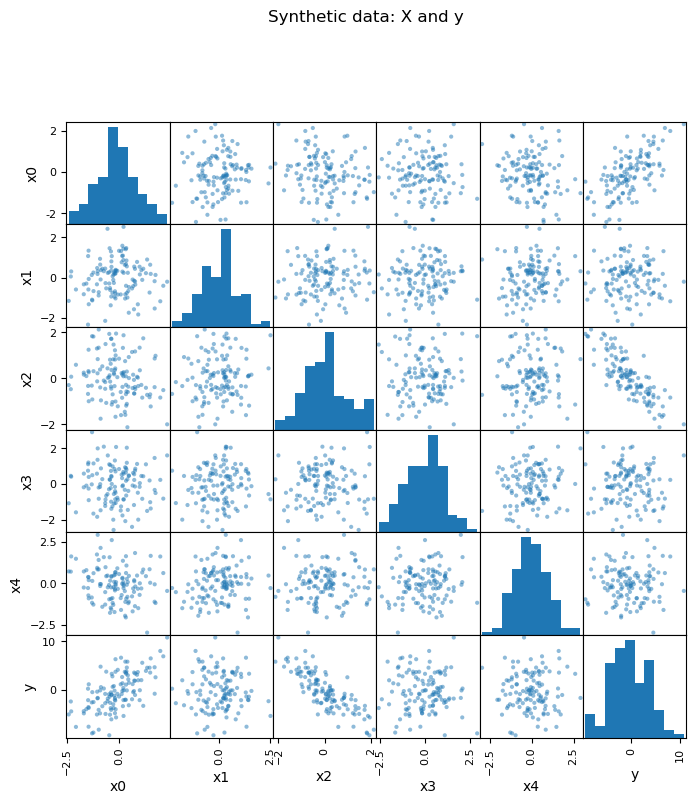

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, betas, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Diffuse Normal Prior Model summary:


mean     sd  hdi_3%  hdi_97%
intercept -0.121  0.093  -0.307    0.043
betas[0]   2.072  0.104   1.878    2.266
betas[1]  -0.015  0.108  -0.231    0.172
betas[2]  -3.067  0.103  -3.269   -2.876
betas[3]  -0.041  0.090  -0.206    0.129
betas[4]   0.475  0.095   0.292    0.649
sigma      1.031  0.070   0.902    1.165

/opt/conda/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



Diffuse model ELPD_WAIC: -177.09021600252703
Diffuse model ELPD_LOO : -177.14591781607425
Diffuse model WAIC (approx) = 354.18
Diffuse model LOO  (approx) = 354.29


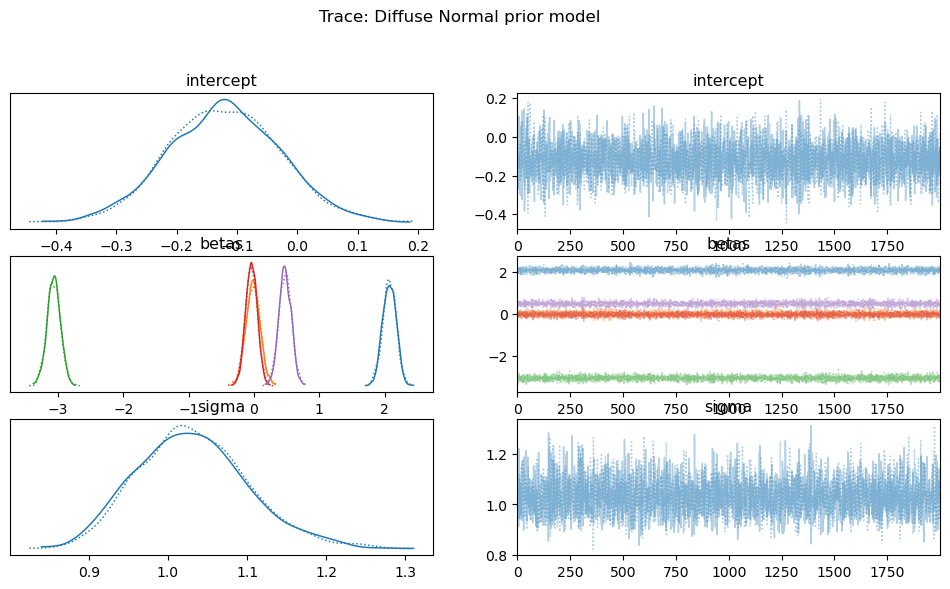

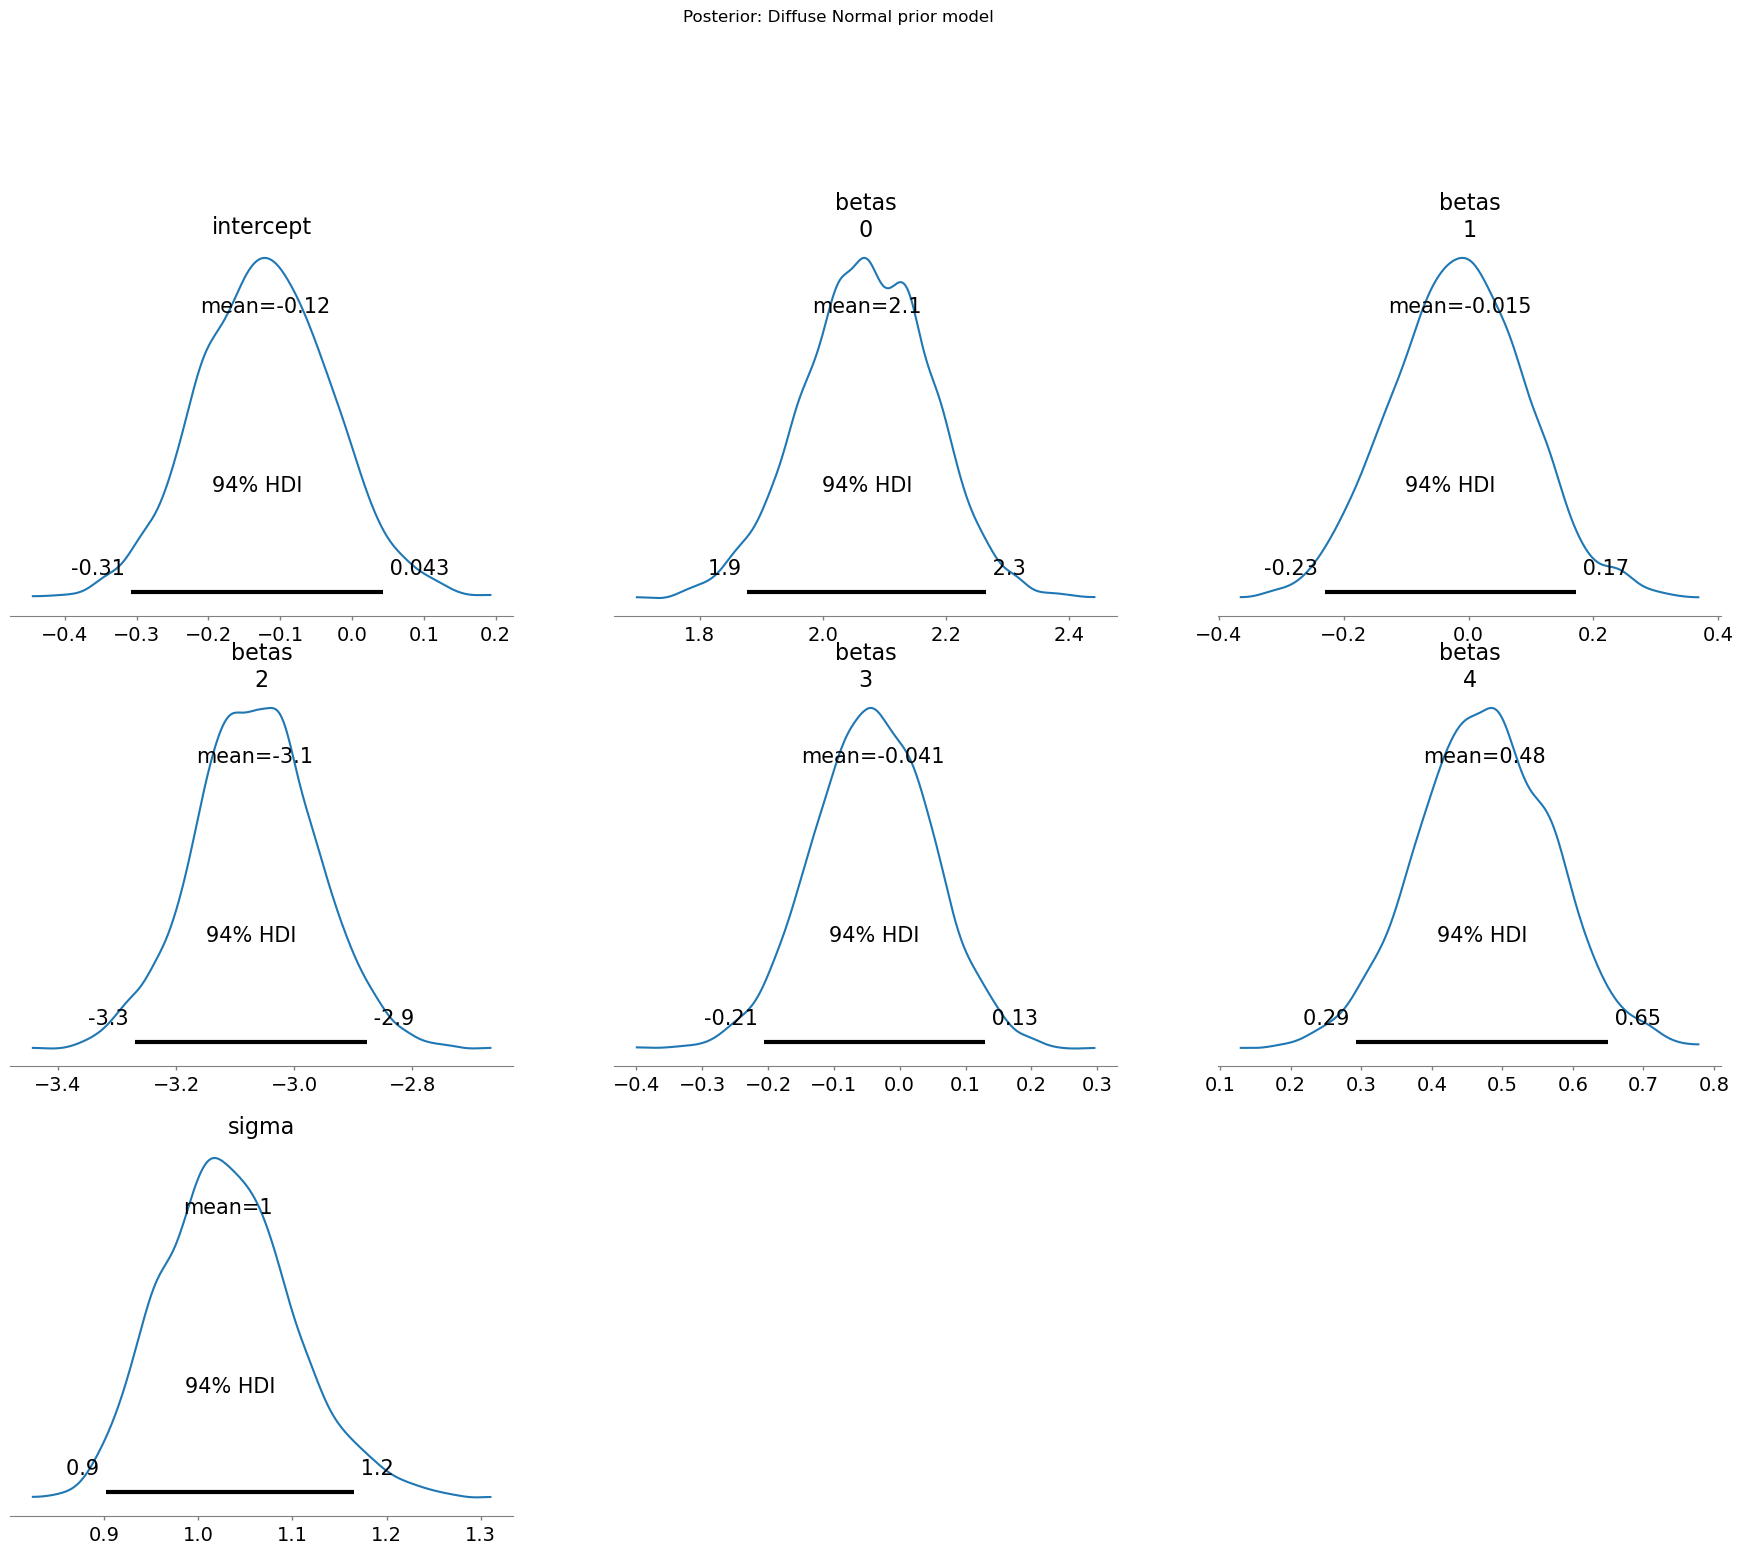

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pi, intercept, sigma, beta_0, beta_1, beta_2, beta_3, beta_4]


Sampling 2 chains for 1_500 tune and 2_500 draw iterations (3_000 + 5_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Spike-and-Slab Model summary:


mean     sd  hdi_3%  hdi_97%
intercept -0.121  0.093  -0.294    0.054
sigma      1.023  0.066   0.901    1.148
beta_0     2.071  0.098   1.884    2.253
beta_1    -0.000  0.021  -0.020    0.023
beta_2    -3.071  0.106  -3.269   -2.870
beta_3    -0.001  0.016  -0.020    0.020
beta_4     0.467  0.093   0.285    0.627
pi_0       0.668  0.235   0.249    1.000
pi_1       0.343  0.237   0.000    0.769
pi_2       0.666  0.234   0.246    1.000
pi_3       0.334  0.236   0.000    0.755
pi_4       0.671  0.234   0.251    1.000

/opt/conda/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



Spike-and-Slab model ELPD_WAIC: -175.0275971175327
Spike-and-Slab model ELPD_LOO : -175.04790765175568
Spike-and-Slab model WAIC (approx) = 350.06
Spike-and-Slab model LOO  (approx) = 350.10


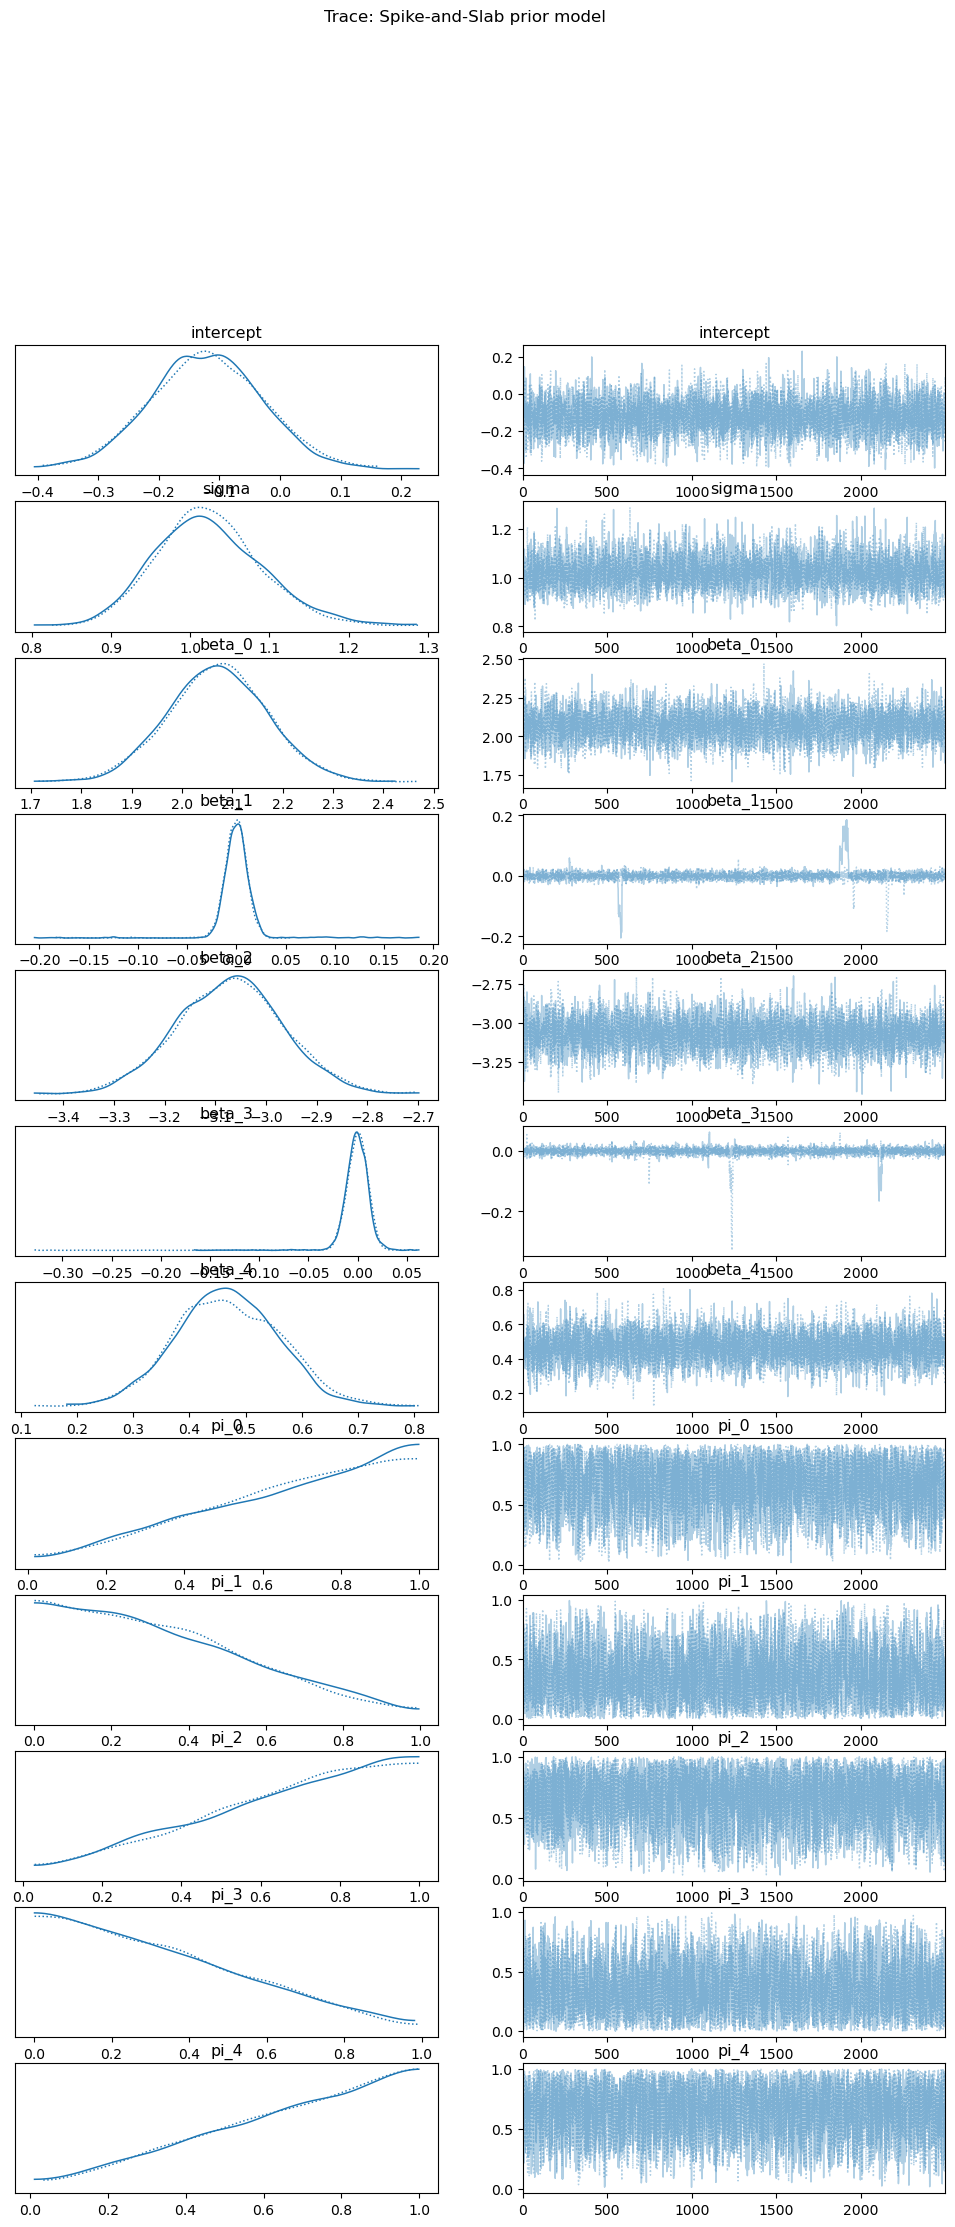

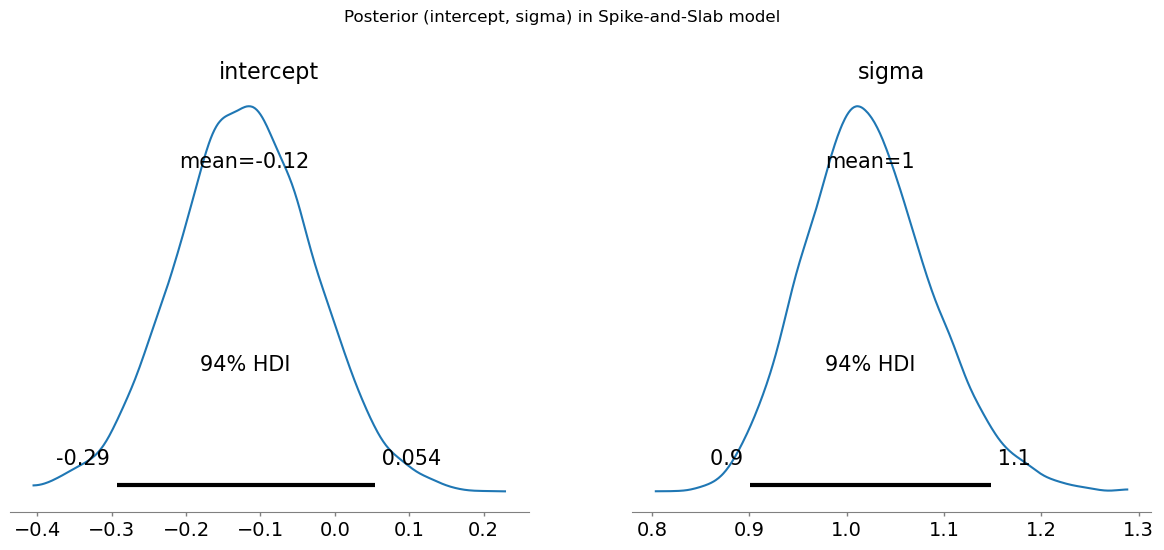

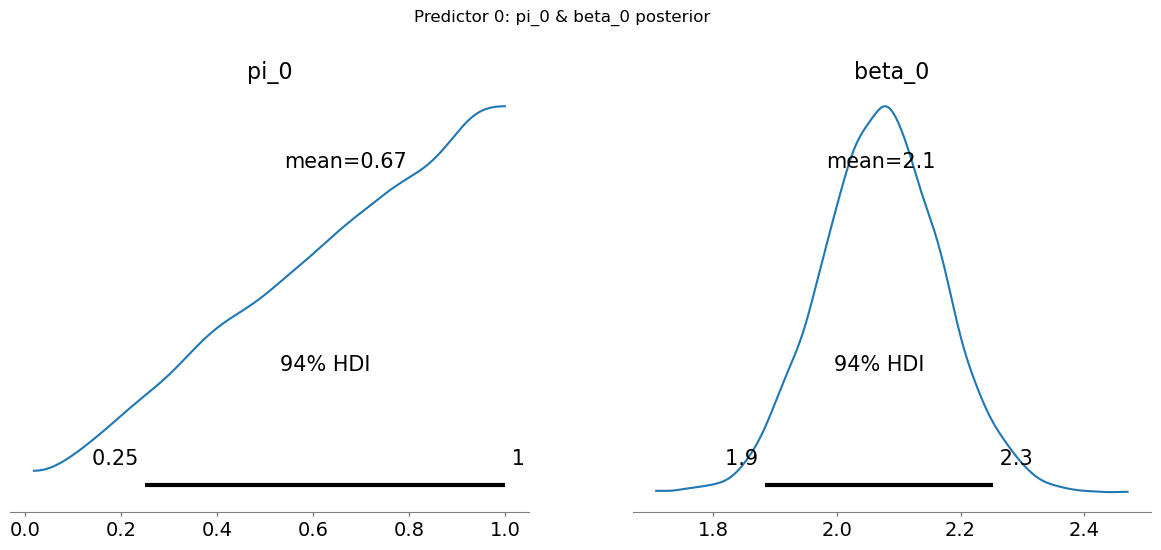

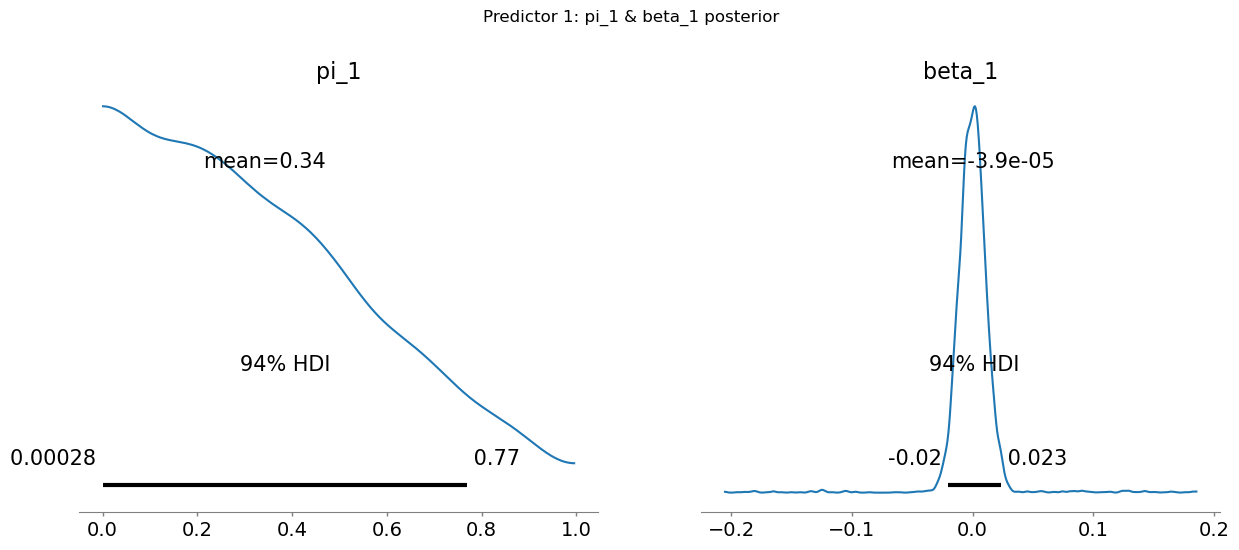

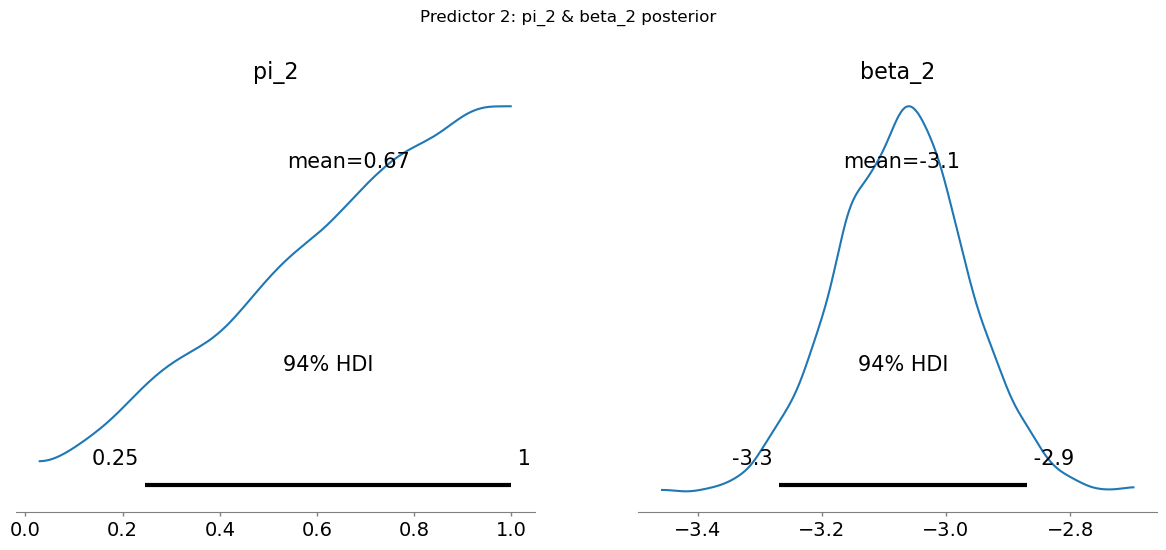

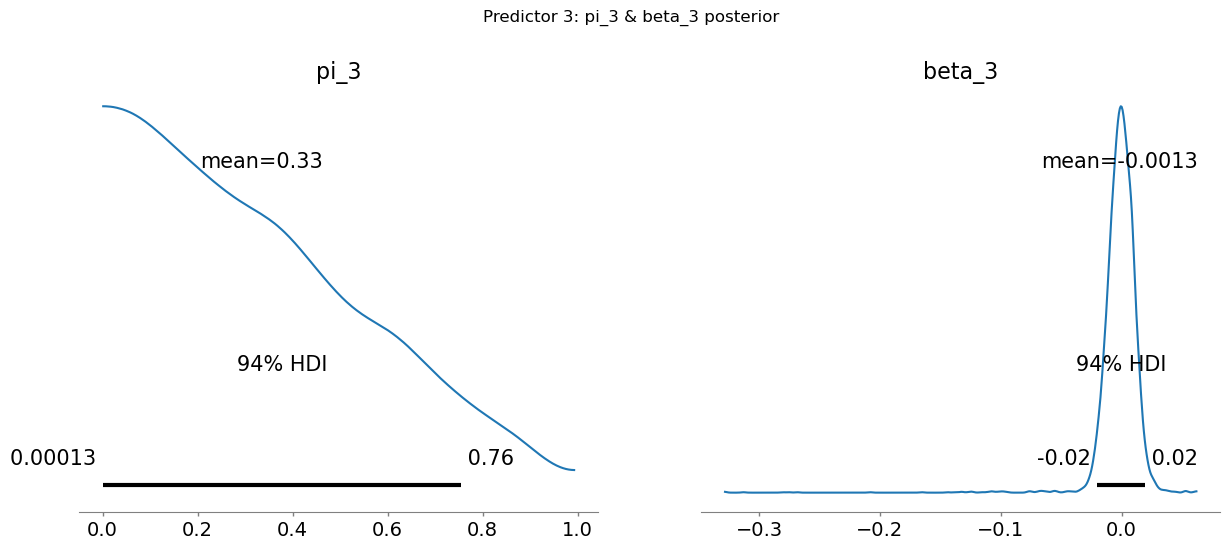

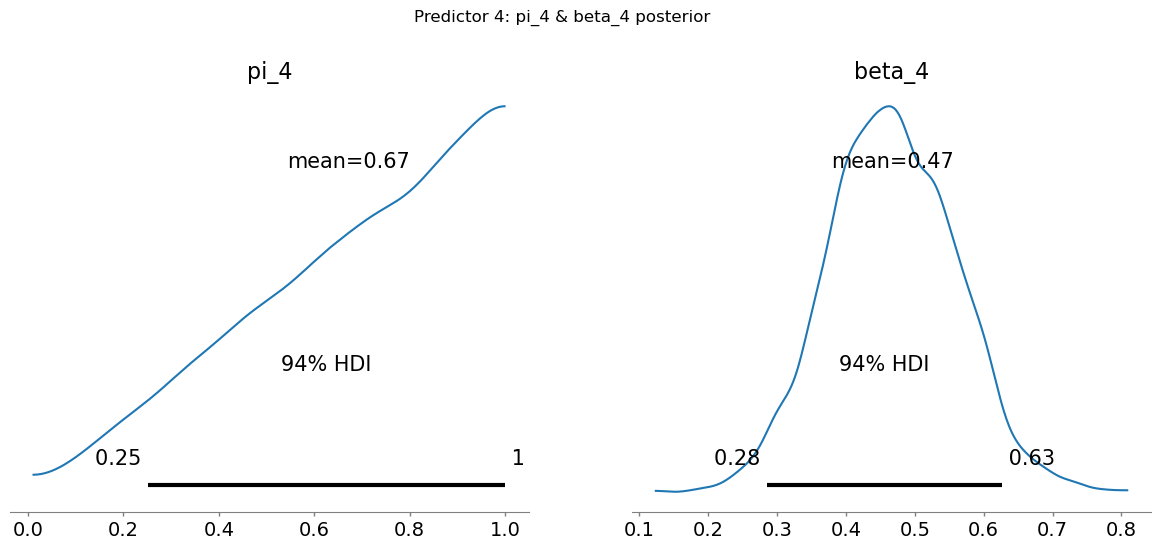

In [6]:
############################################################
# Q2: Variable Selection with Spike-and-Slab vs. Diffuse Normal Priors
#
# 1) Generate synthetic regression data with p=5 predictors, some zero coefficients.
# 2) Fit two models:
#    - Model 1: Diffuse Normal prior (no explicit selection).
#    - Model 2: Spike-and-Slab prior for variable selection, 
#      defining each beta_j as a mixture of "spike" and "slab".
# 3) Compare WAIC/LOO in ArviZ, storing log_likelihood in the InferenceData
#    so we can do az.waic(...) or az.loo(...).
# 4) Avoid KeyError about 'pi[...]' by creating Deterministic nodes pi_{j} for each dimension,
#    so we can reference them in var_names. Similarly, each beta_j is named "beta_{j}".
#
# Requirements:
#  - PyMC >= 4.0
#  - ArviZ >= 0.12
#  - This code should run without KeyError or missing log_likelihood errors.

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# (A) Generate Synthetic Data
# ---------------------------------------------------------
rng = np.random.default_rng(42)
n = 120   # number of observations
p = 5     # number of predictors

beta_true = np.array([2.0, 0.0, -3.0, 0.0, 0.5])
X = rng.normal(0, 1, size=(n, p))
sigma_true = 1.0
noise = rng.normal(0, sigma_true, size=n)
y = X @ beta_true + noise

df = pd.DataFrame(X, columns=[f"x{i}" for i in range(p)])
df["y"] = y

pd.plotting.scatter_matrix(df, figsize=(8,8), diagonal="hist", alpha=0.5)
plt.suptitle("Synthetic data: X and y", y=1.02)
plt.show()

# ---------------------------------------------------------
# (B) Model 1: Diffuse Normal Prior
# ---------------------------------------------------------
with pm.Model() as model_diffuse:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=10, shape=p)
    sigma = pm.HalfCauchy("sigma", beta=5)

    mu = intercept + pm.math.dot(X, betas)
    # Observed var "y_obs"
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Return an InferenceData with log_likelihood
    trace_diffuse = pm.sample(
        draws=2000, tune=1000, target_accept=0.9,
        random_seed=42, cores=1,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

print("Diffuse Normal Prior Model summary:")
display(az.summary(trace_diffuse, var_names=["intercept","betas","sigma"], kind="stats"))

# Evaluate WAIC/LOO referencing var_name="y_obs"
diffuse_waic = az.waic(trace_diffuse, var_name="y_obs")
diffuse_loo  = az.loo(trace_diffuse, var_name="y_obs")
print("\nDiffuse model ELPD_WAIC:", diffuse_waic.elpd_waic)
print("Diffuse model ELPD_LOO :", diffuse_loo.elpd_loo)
print(f"Diffuse model WAIC (approx) = {-2*diffuse_waic.elpd_waic:.2f}")
print(f"Diffuse model LOO  (approx) = {-2*diffuse_loo.elpd_loo:.2f}")

az.plot_trace(trace_diffuse, var_names=["intercept","betas","sigma"])
plt.suptitle("Trace: Diffuse Normal prior model", y=1.02)
plt.show()

az.plot_posterior(trace_diffuse, var_names=["intercept","betas","sigma"])
plt.suptitle("Posterior: Diffuse Normal prior model", y=1.02)
plt.show()

# ---------------------------------------------------------
# (C) Model 2: Spike-and-Slab Prior
# ---------------------------------------------------------
p_spike = p
spike_sigma = 0.01
slab_sigma  = 5.0

with pm.Model() as model_spike_slab:
    # Probability for each predictor to be "on"
    pi = pm.Beta("pi", alpha=1, beta=1, shape=p_spike)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=5)

    betas_list = []
    for j in range(p_spike):
        spike_dist = pm.Normal.dist(mu=0, sigma=spike_sigma)
        slab_dist  = pm.Normal.dist(mu=0, sigma=slab_sigma)
        w_j = pi[j]
        # mixture for each beta_j
        beta_j = pm.Mixture(
            f"beta_{j}",
            w=[1 - w_j, w_j],
            comp_dists=[spike_dist, slab_dist]
        )
        betas_list.append(beta_j)

    # Also define Deterministic nodes for pi_j to avoid KeyError
    for j in range(p_spike):
        _ = pm.Deterministic(f"pi_{j}", pi[j])

    betas_spike = pm.math.stack(betas_list, axis=0)
    mu2 = intercept + pm.math.dot(X, betas_spike)
    y_obs2 = pm.Normal("y_obs", mu=mu2, sigma=sigma, observed=y)

    trace_spike_slab = pm.sample(
        draws=2500, tune=1500, target_accept=0.95,
        random_seed=42, cores=1,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

# Summaries: we can list each "beta_{j}" and "pi_{j}"
varnames_spike = ["intercept","sigma"] + [f"beta_{j}" for j in range(p_spike)] + [f"pi_{j}" for j in range(p_spike)]
print("\nSpike-and-Slab Model summary:")
display(az.summary(trace_spike_slab, var_names=varnames_spike, kind="stats"))

# WAIC/LOO
spike_waic = az.waic(trace_spike_slab, var_name="y_obs")
spike_loo  = az.loo(trace_spike_slab, var_name="y_obs")
print("\nSpike-and-Slab model ELPD_WAIC:", spike_waic.elpd_waic)
print("Spike-and-Slab model ELPD_LOO :", spike_loo.elpd_loo)
print(f"Spike-and-Slab model WAIC (approx) = {-2*spike_waic.elpd_waic:.2f}")
print(f"Spike-and-Slab model LOO  (approx) = {-2*spike_loo.elpd_loo:.2f}")

az.plot_trace(trace_spike_slab, var_names=varnames_spike)
plt.suptitle("Trace: Spike-and-Slab prior model", y=1.02)
plt.show()

# Posterior partial
az.plot_posterior(trace_spike_slab, var_names=["intercept","sigma"])
plt.suptitle("Posterior (intercept, sigma) in Spike-and-Slab model", y=1.02)
plt.show()

# Inspect each predictor's pi_j and beta_j
for j in range(p_spike):
    az.plot_posterior(trace_spike_slab, var_names=[f"pi_{j}", f"beta_{j}"])
    plt.suptitle(f"Predictor {j}: pi_{j} & beta_{j} posterior", y=1.02)
    plt.show()


# Explanation

**1) Overview**  
We perform a multivariate regression (actually univariate $y$ with $p$ predictors) with two different priors on the coefficients:
1. A **diffuse Normal prior**: $\beta_j \sim \mathcal{N}(0,10^2)$.
2. A **spike-and-slab prior**: $\beta_j$ is drawn from a mixture of a “spike” distribution (very small $\sigma$, near zero) and a “slab” distribution (larger $\sigma$), with mixing weight $w_j$ drawn from a Bernoulli($\pi_j$). This allows each predictor to be effectively “turned off” (spike) or “on” (slab).

**2) Synthetic Data**  
- We generate $X$ of size $n \times p$ and a true $\beta_{\text{true}}$ with some zeros to mimic variable selection.  
- The outcome is $y = X\beta_{\text{true}} + \epsilon$.  

**3) Diffuse Normal Prior Model**  
- We place $\beta_j \sim \mathrm{Normal}(0, 10)$ for all $j$.  
- We fit the model in PyMC, then compute WAIC/LOO for model comparison.

**4) Spike-and-Slab Model**  
- For each coefficient $\beta_j$, we define a mixture of two Gaussians:  
  $$\beta_j \sim (1-w_j) \mathcal{N}(0,\sigma_{\mathrm{spike}}^2) \;+\; w_j\, \mathcal{N}(0,\sigma_{\mathrm{slab}}^2),$$  
  with $w_j \sim \mathrm{Bernoulli}(\pi_j)$.  
- In PyMC, we use `pm.Mixture(...)` to handle each $\beta_j$. This approach is computationally intensive because $w_j$ is discrete.  
- After fitting, we can check which $w_j$ are near 1 or 0, indicating which predictors are “selected”.

**5) Model Comparison**  
- We use WAIC or LOO from ArviZ to compare the two models.  
- The spike-and-slab model may yield better predictive performance if the data truly has many zero coefficients.  
- However, the diffuse normal model might do similarly if the signal is strong or if $p$ is small.

**6) Practical Considerations**  
- Discrete variable selection (Bernoulli $w_j$) can cause slow mixing in MCMC. For large $p$, more advanced methods (like continuous shrinkage priors, e.g. horseshoe) are often used.  
- If $n$ is much smaller than $p$, we might reduce data size or do more advanced regularization.  
- In a truly **multivariate** sense (multiple $y$ dimensions), each dimension can have its own spike-and-slab or we can share indicators across dimensions. We can also combine this with the correlation modeling approach from prior notebooks (like the copula approach or a multivariate normal likelihood with a covariance prior).

**7) Interpretation**  
- If the posterior for $\pi_j$ is near 1, that predictor is strongly “on.” If near 0, it’s likely “off.”  
- The posterior distribution of $\beta_j$ typically shows a mass near 0 if $w_j=0$ is favored.  
- By comparing the two models’ WAIC or LOO, we can see if the spike-and-slab approach improves out-of-sample predictive performance relative to the simpler diffuse normal prior.

This demonstrates how spike-and-slab priors enable variable selection in a Bayesian framework, balancing fit and complexity. 


# Q3

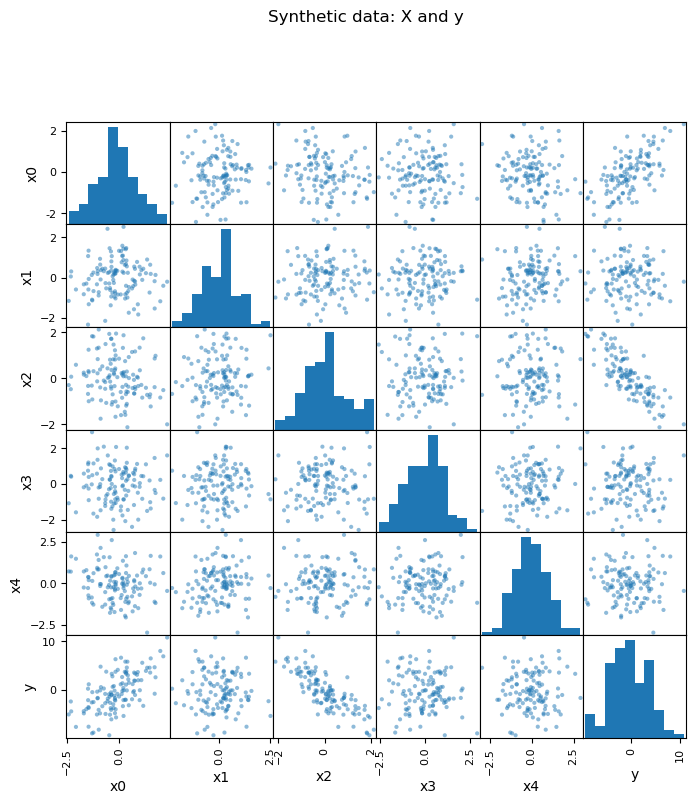

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, lam, intercept, sigma, betas]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Horseshoe Prior Model summary:


mean      sd  hdi_3%  hdi_97%
intercept -0.122   0.093  -0.294    0.054
sigma      1.027   0.066   0.908    1.155
tau        1.080   0.831   0.094    2.521
lam[0]     4.202   7.130   0.309   11.106
lam[1]     0.555   1.239   0.004    1.582
lam[2]     6.296  13.218   0.269   16.513
lam[3]     0.507   0.928   0.003    1.542
lam[4]     1.366   2.085   0.056    3.523
betas[0]   2.061   0.102   1.869    2.252
betas[1]  -0.008   0.086  -0.184    0.154
betas[2]  -3.064   0.102  -3.257   -2.877
betas[3]  -0.029   0.075  -0.174    0.112
betas[4]   0.454   0.092   0.284    0.629

/opt/conda/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(



Horseshoe model ELPD_WAIC: -176.27134638111252
Horseshoe model ELPD_LOO : -176.31928160617417
Horseshoe model WAIC (approx) = 352.54
Horseshoe model LOO  (approx) = 352.64


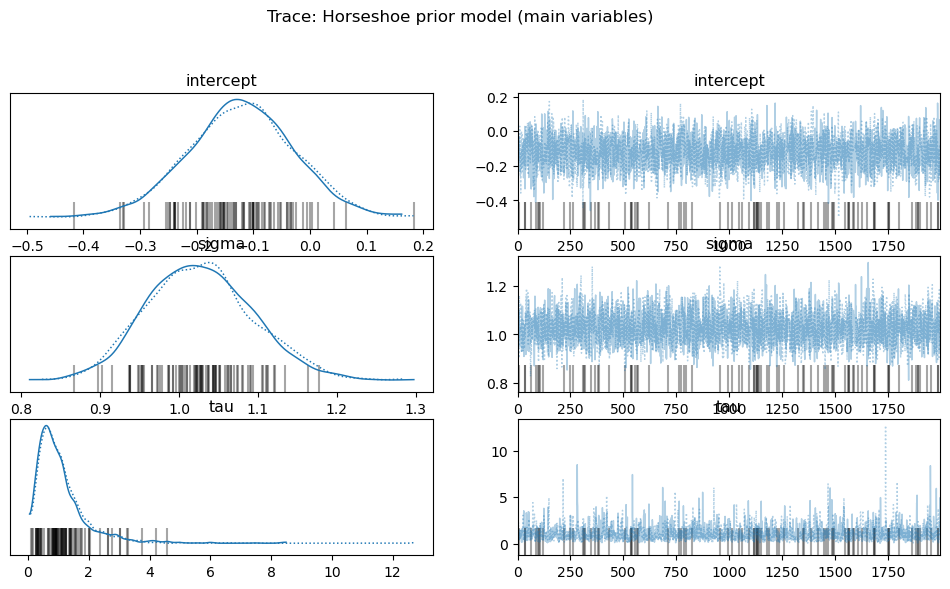

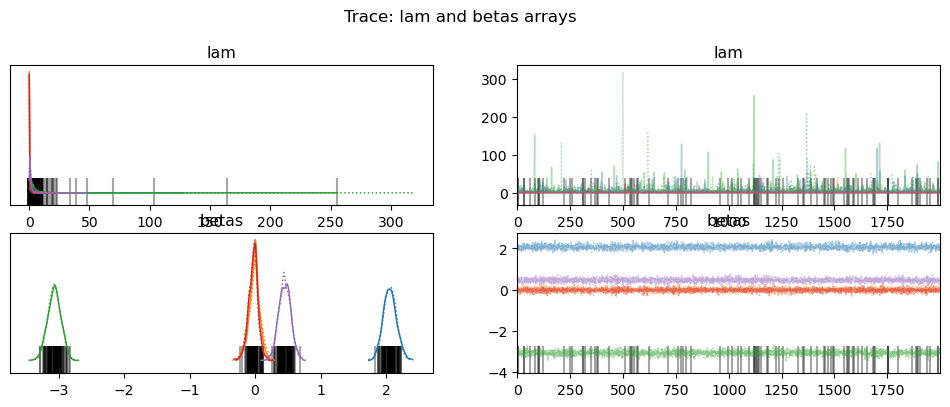

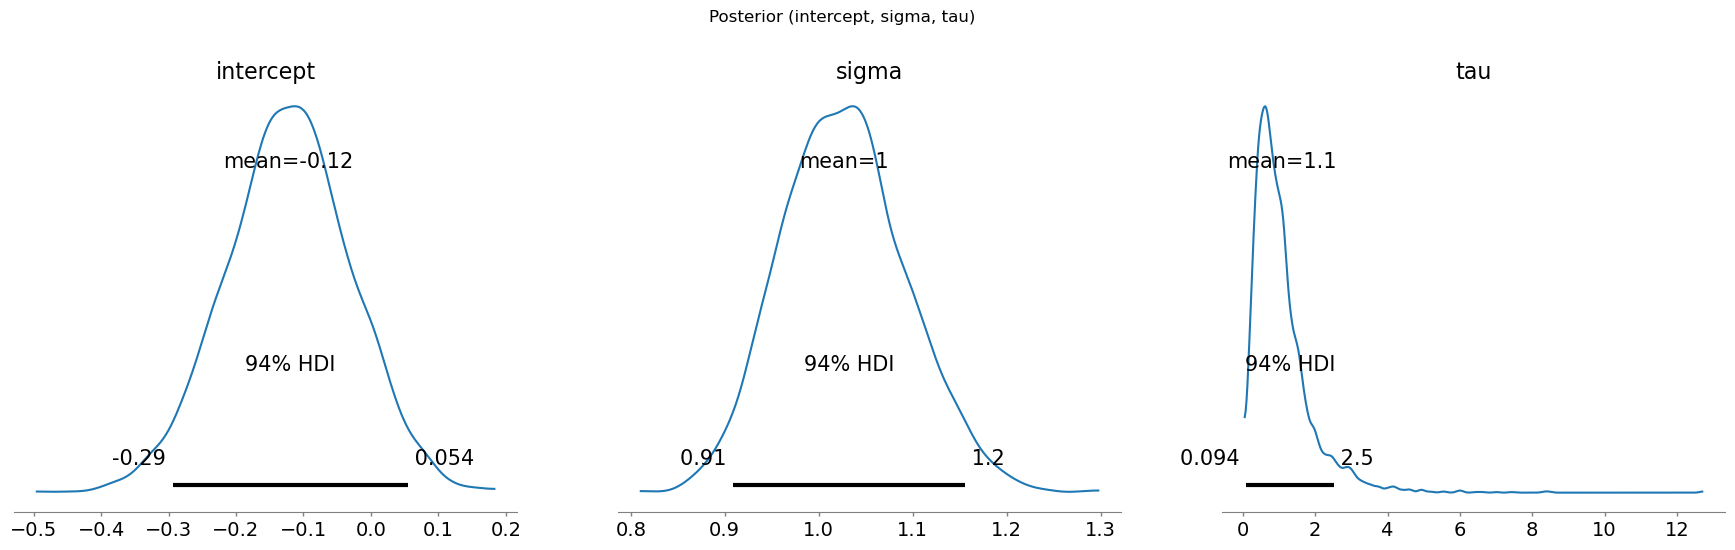

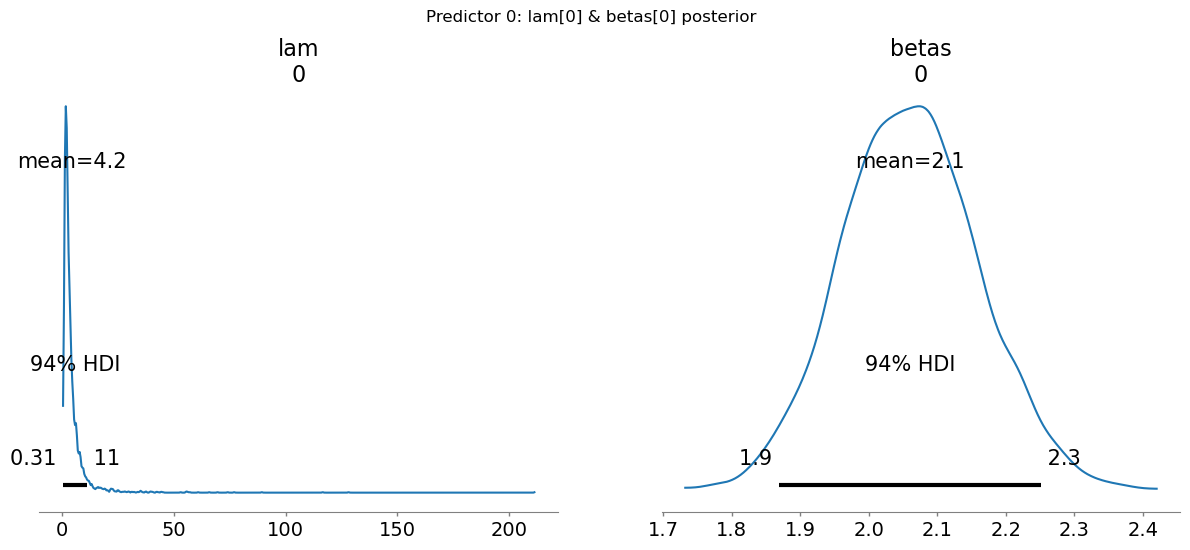

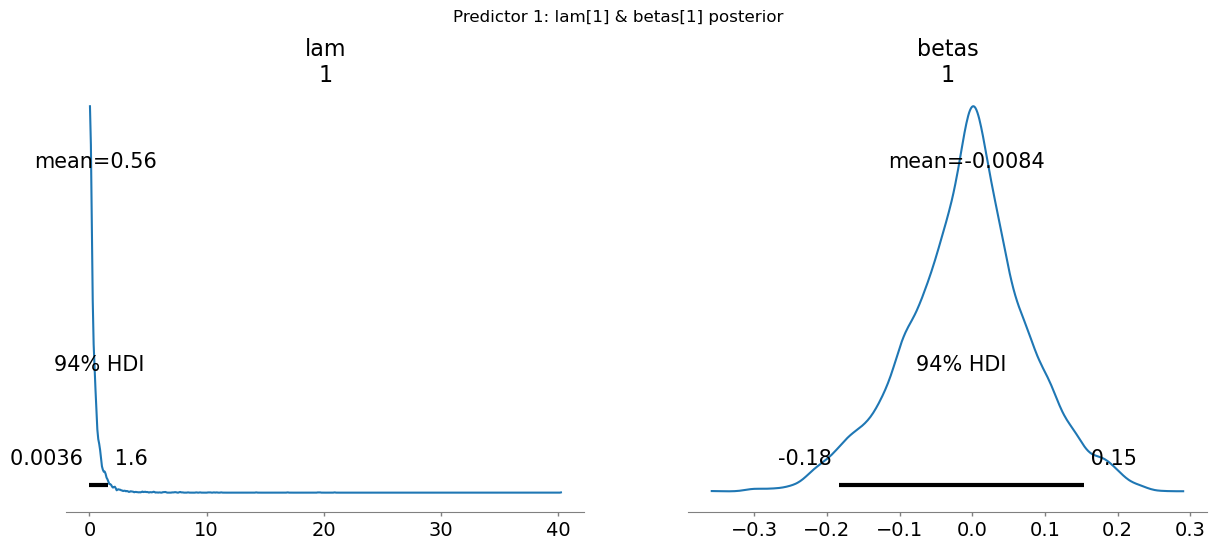

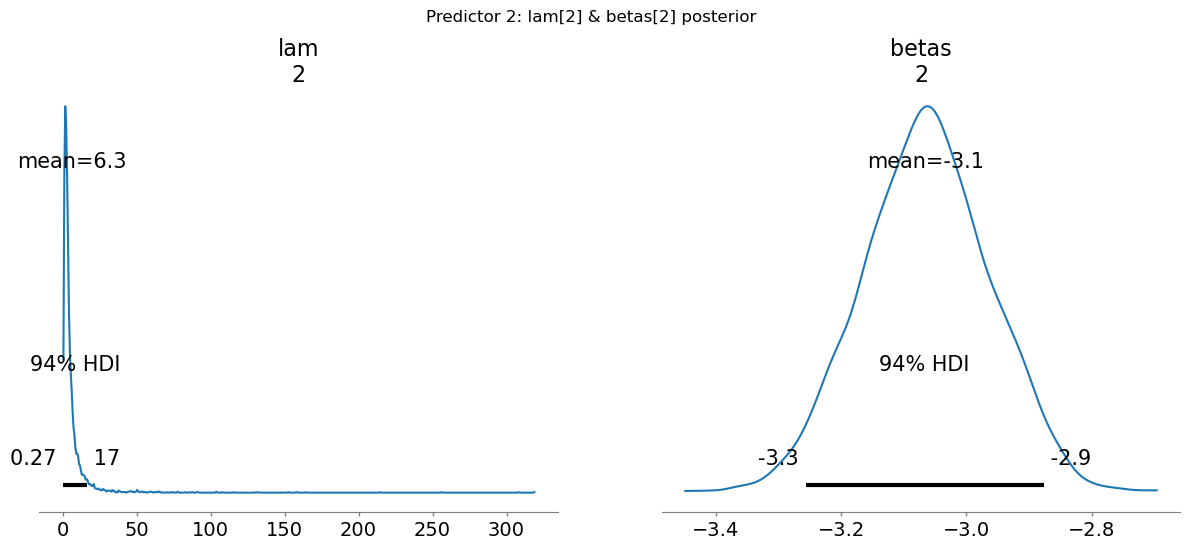

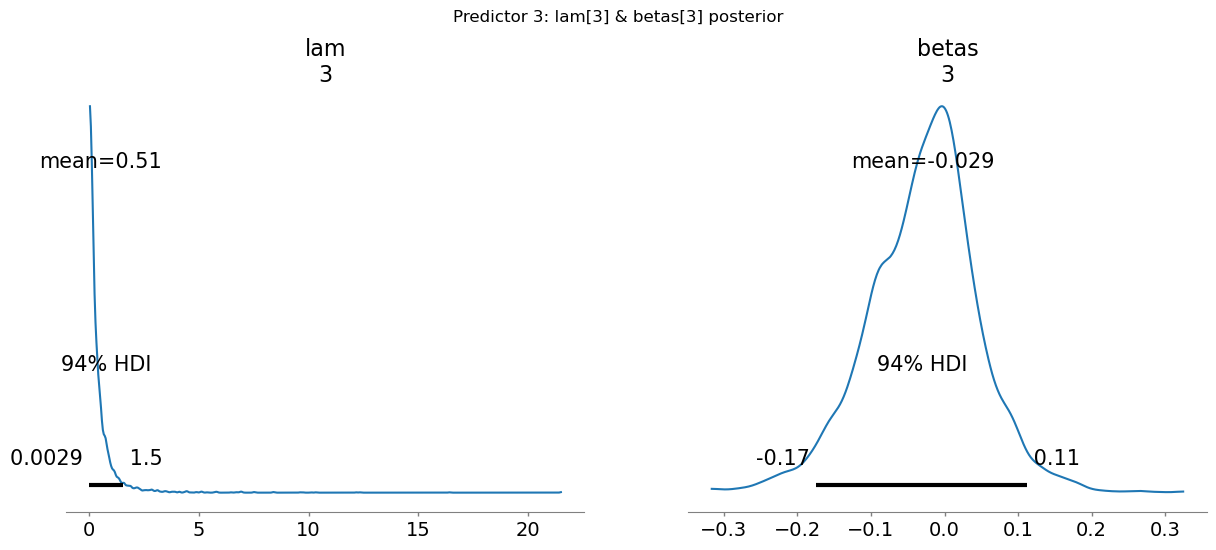

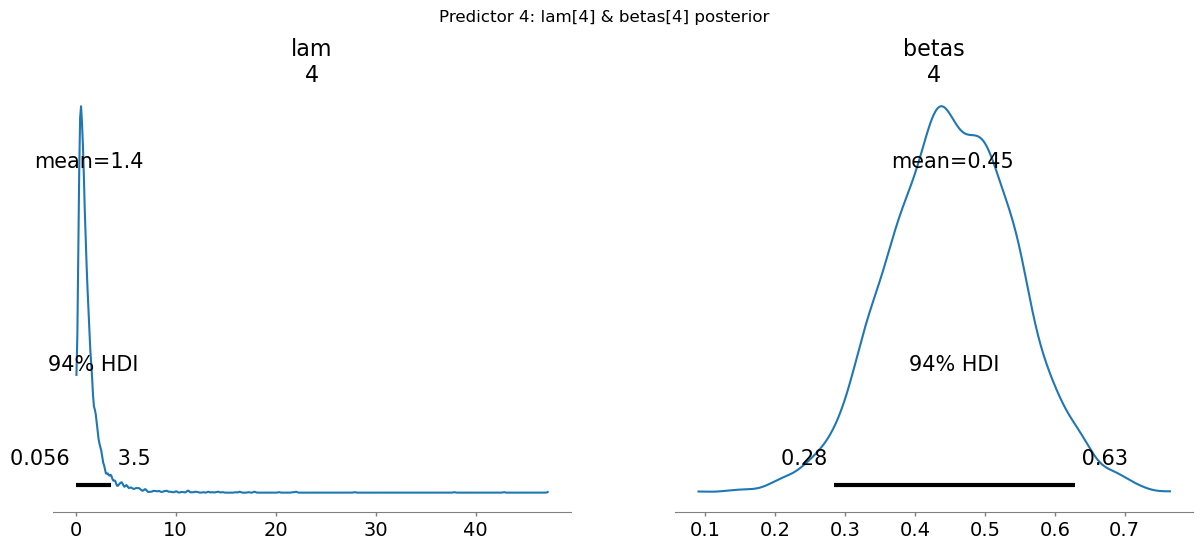

In [9]:
############################################################
# Q3: Variable Selection Using Horseshoe Priors vs. Spike-and-Slab
#
# 1) Generate synthetic regression data with p=5 predictors, some zero coefficients.
# 2) Fit a Horseshoe prior model for variable selection:
#    w_i ~ Normal(0, tau * lam[i]), lam[i] ~ HalfCauchy(1), tau ~ HalfCauchy(1).
# 3) Compare inference to a spike-and-slab approach (previous question),
#    but here we focus on the Horseshoe.
# 4) We fix KeyError issues by:
#    - Defining lam, betas as array variables with shape=p.
#    - Summarizing them in ArviZ by referencing the entire variable name "lam","betas"
#      and specifying 'coords' to pick dimension indexes for partial plots.
# 5) We store log_likelihood for WAIC/LOO in ArviZ, ensuring no 'log likelihood not found' errors.

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# (A) Generate Synthetic Data
# ---------------------------------------------------------
rng = np.random.default_rng(42)
n = 120   # number of observations
p = 5     # number of predictors

beta_true = np.array([2.0, 0.0, -3.0, 0.0, 0.5])
X = rng.normal(0, 1, size=(n, p))
sigma_true = 1.0
noise = rng.normal(0, sigma_true, size=n)
y = X @ beta_true + noise

df = pd.DataFrame(X, columns=[f"x{i}" for i in range(p)])
df["y"] = y

pd.plotting.scatter_matrix(df, figsize=(8,8), diagonal="hist", alpha=0.5)
plt.suptitle("Synthetic data: X and y", y=1.02)
plt.show()

# ---------------------------------------------------------
# (B) Horseshoe Prior Model
# ---------------------------------------------------------
# We'll define:
#   tau ~ HalfCauchy(1)
#   lam[i] ~ HalfCauchy(1) for i in [0..p-1]
#   betas[i] ~ Normal(0, tau*lam[i])
# plus intercept and noise sigma

with pm.Model() as model_horseshoe:
    tau = pm.HalfCauchy("tau", beta=1.0)
    lam = pm.HalfCauchy("lam", beta=1.0, shape=p)   # local scales, shape=p

    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=5)

    betas = pm.Normal("betas", mu=0, sigma=tau*lam, shape=p)

    mu = intercept + pm.math.dot(X, betas)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace_horseshoe = pm.sample(
        draws=2000, tune=1000, target_accept=0.9,
        random_seed=42, cores=1,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )

# Summaries: we can reference the array variables by name
varnames_horse = ["intercept","sigma","tau","lam","betas"]
print("\nHorseshoe Prior Model summary:")
display(az.summary(trace_horseshoe, var_names=varnames_horse, kind="stats"))

# Evaluate WAIC/LOO referencing the observed var_name="y_obs"
horse_waic = az.waic(trace_horseshoe, var_name="y_obs")
horse_loo  = az.loo(trace_horseshoe, var_name="y_obs")

print("\nHorseshoe model ELPD_WAIC:", horse_waic.elpd_waic)
print("Horseshoe model ELPD_LOO :", horse_loo.elpd_loo)
print(f"Horseshoe model WAIC (approx) = {-2*horse_waic.elpd_waic:.2f}")
print(f"Horseshoe model LOO  (approx) = {-2*horse_loo.elpd_loo:.2f}")

# Trace plots for top-level variables (arrays won't show each dimension individually by default)
az.plot_trace(trace_horseshoe, var_names=["intercept","sigma","tau"])
plt.suptitle("Trace: Horseshoe prior model (main variables)", y=1.02)
plt.show()

# We can also do partial trace for "lam" or "betas"
# but let's do an array-level plot
az.plot_trace(trace_horseshoe, var_names=["lam","betas"])
plt.suptitle("Trace: lam and betas arrays", y=1.02)
plt.show()

# Posterior partial
az.plot_posterior(trace_horseshoe, var_names=["intercept","sigma","tau"])
plt.suptitle("Posterior (intercept, sigma, tau)", y=1.02)
plt.show()

# (C) Dimension-by-dimension Posterior Plots
# We can't do var_names=["lam[0]"] or "betas[0]" directly in new PyMC/ArviZ,
# we specify coords={"lam_dim_0":[0]} for the 0th dimension, etc.

for j in range(p):
    az.plot_posterior(
        trace_horseshoe,
        var_names=["lam","betas"],
        coords={"lam_dim_0": [j], "betas_dim_0": [j]},
    )
    plt.suptitle(f"Predictor {j}: lam[{j}] & betas[{j}] posterior", y=1.02)
    plt.show()


# Explanation

### 1) Horseshoe Prior Overview
The Horseshoe prior is a **continuous shrinkage** prior that helps in sparse variable selection. It uses:
- A **global scale** parameter $\tau \sim \mathrm{HalfCauchy}(1)$ that controls overall shrinkage.
- A set of **local scales** $\lambda_j \sim \mathrm{HalfCauchy}(1)$, one per coefficient, which can be very large for relevant predictors (leading to minimal shrinkage) or remain small for irrelevant predictors (leading to strong shrinkage).

The coefficient is then:
$$
\beta_j \sim \mathcal{N}\bigl(0,\;\tau^2\,\lambda_j^2\bigr).
$$

### 2) Synthetic Data
We generate $n=120$ data points, $p=5$ predictors, with a true $\beta$ having some zero entries. The response is $y = X \beta + \epsilon$.

### 3) Model Specification
In PyMC:
1. `tau = pm.HalfCauchy("tau", beta=1)` is the global scale.  
2. `lambda_ = pm.HalfCauchy("lambda", beta=1, shape=p)` are the local scales.  
3. `betas = pm.Normal("betas", mu=0, sigma=tau * lambda_, shape=p)` define the actual regression coefficients.  
4. We define `intercept` and noise scale `sigma` as well.  
5. The likelihood is `pm.Normal("y_obs", mu=..., sigma=..., observed=y)`.

### 4) Inference and WAIC/LOO
- We run `pm.sample(...)` with `return_inferencedata=True` and `idata_kwargs={"log_likelihood": True}` so ArviZ can compute WAIC/LOO.  
- The returned `trace_horseshoe` is an InferenceData. We call:
  ```python
  horseshoe_waic = az.waic(trace_horseshoe, var_name="y_obs")
  horseshoe_loo  = az.loo(trace_horseshoe, var_name="y_obs")
